# Lab: Deep Metric Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/antoninofurnari/deeplearning/blob/main/notebooks/24-03-26-deep-metric-learning.ipynb
)

**Course:** Deep Learning: Advanced Models and Methods

**Instructor:** Antonino Furnari

**Duration:** 2 Hours (In-class Group Lab)

## 📝 Lab Format & Deliverables
* **Format:** 
  * Students work in groups of 1-3.
  * The teacher gives a brief introduction to the lab, then students work independently with support from the teacher.
* **Strategy:** 
  * Fill in the ☑️ `TODO` blocks. Do not modify the provided boilerplate unless necessary.
  * Check that you obtained reasonable results through the 🛑 `Checkpoints`.
  * Fill in the short 📝 `Reflections` where required.
  * Reach 🏁 `Milestones`.
* **Submission:**
  * Fill in this notebook and send it to <antonino.furnari@unict.it> as an `.ipynb` by the end of the lab
* **Grading:**
  * Notebooks will be graded in binary way as passed / not passed based on completion (did the group reach all milestones successfully? are reflections adequate?)
  * Each notebook is worth $0.5$ bonus points. These are assigned to students individually (not to groups).
* **Computation:**
  * Run this notebook on Google Colab or Kaggle with GPU acceleration.

You will find the following blocks throughout the notebook:

<div class="alert alert-block alert-info">
<b>☑️ TODO</b> This box provides you instruction on a TODO that should be completed in the code cells below.
</div>

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint</b> The following cells provide you instruction on what you should observe if you run a given cell after having implemented your TODOs. This serve as a self-check to assess potential bugs or errors early.
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection</b> You are required to write a short reflection on your results.
</div>

<div class="alert alert-block alert-success">
<b>🏁 Milestone</b> This signal that you completed a significant part of the notebook and reached a milestone.
</div>

## Your Data
<div class="alert alert-block alert-warning">
<b>📝 Date and Team Composition</b>

<i>Insert the current date, plus names, surnames, matricola, and emails of the team members below:</i>

**Date:** YYYY-MM-DD

**Link to wandb:** <a href="example_link">link</a>

| Name | Surname | Matricola | Email |
|---|---:|---:|---|
| Name 1 | Surname1 | 0000001 | <a href="mailto:member1@example.com">member1@example.com</a> |
| Name 2 | Surname2 | 0000002 | <a href="mailto:member2@example.com">member2@example.com</a> |
| Name 3 | Surname3 | 0000003 | <a href="mailto:member3@example.com">member3@example.com</a> |
</div>

## Introduction and Problem Setup

### 🎯 Learning Goals
In this lab, you will explore the progression of Deep Metric Learning from training custom networks to leveraging modern Foundation Models. 

You will implement the state-of-the-art **ArcFace** loss and compare it against standard classification baselines. 

You will assess Deep Metric Learning in two settings: 

1. Training a model from scratch;
2. Training a lightweight MLP adapter on top of features extracted with a DINOv2 foundation model.

### Problem Setup
We will consider a face recognition problem for this laboratory. Face recognition is one of the most challenging problems in computer vision. Unlike controlled laboratory settings, real-world face recognition must handle:

- **Pose Variation:** Faces at different angles (frontal, profile, tilted)
- **Lighting Conditions:** Harsh shadows, bright backlighting, indoor/outdoor differences
- **Facial Expressions:** Smiling, neutral, or emotional expressions
- **Occlusions:** Glasses, masks, or partial visibility
- **Image Quality:** Low resolution, motion blur, or compression artifacts

Traditional machine learning approaches (e.g., comparing raw pixel values or hand-crafted features) fail dramatically in these conditions because they cannot capture the semantic similarity between two images of the *same person* under different conditions.

### The Dataset: Labeled Faces in the Wild (LFW)
We use **LFW**, a publicly available dataset containing 13,233 face images of 5,749 different people collected from the internet. The dataset is intentionally "in-the-wild"—meaning it reflects real-world complexity with unconstrained poses, lighting, and expressions.

We will use `scikit-learn` version, where faces have been extracted using the Viola-Jones detector, so they are automatically aligned (https://scikit-learn.org/0.19/datasets/labeled_faces.html).

<img src="http://antoninofurnari.it/downloads/lfw_image_grid.jpg">

To create a challenging **few-shot learning scenario**, we impose a strict constraint:
- **Minimum 5 images per person** (instead of the typical 1-2)
- This yields approximately **400+ identities**, each with 5-10 examples
- Standard classification approaches (Softmax) struggle because there is limited data to learn discriminative features for so many classes.

### The Evaluation Paradigm: Open-Set Recognition

We adopt an **open-set evaluation protocol**:

1. **Training Set:** Images from the first 75% of identities (closed-set training on known classes)
2. **Test Set:** Images from the remaining 25% of identities (completely unseen at training time)

This simulates a realistic scenario: a face recognition system must recognize *new people* it has never encountered before. This is fundamentally different from closed-set classification, where all test classes are seen during training.

### Why Metric Learning Matters

The core challenge is that with limited data and many classes, standard Softmax classification learns poor decision boundaries. **Metric Learning** approaches like **ArcFace** address this by:

- Learning an **embedding space** where same-person faces cluster tightly
- Enforcing an **angular margin** between different identities
- Making the model robust to the few-shot, open-set setting

### Lab Structure

This lab takes a **progressive approach** to understanding metric learning:

1. **Part 1 – From Scratch:** We train a simple CNN from random initialization using both Softmax and ArcFace to see metric learning's advantage on weak backbones with limited data
2. **Part 2 – Foundation Models:** We leverage DinoV2, a state-of-the-art self-supervised Vision Transformer, and ask: *does metric learning still help when the backbone is already powerful?*
3. **Part 3 – Reflections:** We synthesize insights about when and why metric learning is necessary

## Preparation

We will start by installing necessary packages and logging in to `wandb`. Please create an account if you don't have it already.

In [3]:
# @title ⚙️ Setup and Imports
# Install necessary libraries (quiet mode)
!pip install -q pytorch-lightning wandb

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

# Set global seed for reproducibility
pl.seed_everything(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Setup complete. Using device: {device}")

# Weights & Biases Login
WANDB_PROJECT = "dl-lab-metric-learning"
print("\n🚀 Logging in to Weights & Biases...")
try:
    # This will prompt you for your API key if not already logged in
    wandb.login()
    print(f"✅ Login successful! Runs will be logged to project: '{WANDB_PROJECT}'")
except Exception as e:
    print(f"⚠️ Login failed: {e}")
    print("⚠️ Switching to OFFLINE mode. Metrics will be saved locally.")
    os.environ["WANDB_MODE"] = "offline"

Seed set to 42


✅ Setup complete. Using device: cuda

🚀 Logging in to Weights & Biases...


wandb: Currently logged in as: antoninofurnari. Use `wandb login --relogin` to force relogin


✅ Login successful! Runs will be logged to project: 'dl-lab-metric-learning'


The following cell defines some hyperparameters we will reference later:

In [4]:
# @title 💾 Configuration & Data Loading
# CONFIGURATION
BATCH_SIZE = 64
EMBEDDING_DIM = 128
LR = 1e-3
MAX_EPOCHS_PART1 = 50 # Longer training for CNN from scratch
MAX_EPOCHS_PART2 = 10 # Shorter training for MLP on Dino features
MIN_FACES_PER_PERSON = 5 # Hard mode: few samples per person!

### Data Download and Format

The following code cell download the data and splits it appropriately:

In [5]:
print("⏳ Downloading LFW dataset (this may take ~60 seconds)...")
# Resize=0.5 gives approx 62x47 images. Color=True gives 3 channels.
lfw_people = fetch_lfw_people(min_faces_per_person=MIN_FACES_PER_PERSON, resize=0.5, color=True)

images = lfw_people.images # Shape (N, H, W, 3)
targets = lfw_people.target
target_names = lfw_people.target_names

# Permute for PyTorch: (N, H, W, 3) -> (N, 3, H, W)
X = np.transpose(images, (0, 3, 1, 2))
# Normalize to [0, 1] range
if X.max() > 1.0:
    X /= 255.0

X_t = torch.tensor(X, dtype=torch.float32)
y_t = torch.tensor(targets, dtype=torch.long)

# OPEN-SET SPLIT
# Train: First 75% of identities
# Test:  Last 25% of identities (Unseen)
num_classes = len(target_names)
NUM_TRAIN_CLASSES = int(num_classes * 0.75)

train_mask = y_t < NUM_TRAIN_CLASSES
test_mask = y_t >= NUM_TRAIN_CLASSES

X_train, y_train = X_t[train_mask], y_t[train_mask]
X_test, y_test   = X_t[test_mask], y_t[test_mask]

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\n✅ Data Loaded Successfully.")
print(f"   Total Classes: {num_classes}")
print(f"   Train Set: {len(X_train)} images (IDs 0-{NUM_TRAIN_CLASSES-1})")
print(f"   Test Set:  {len(X_test)} images (IDs {NUM_TRAIN_CLASSES}-{num_classes-1}) - UNSEEN IDENTITIES")

⏳ Downloading LFW dataset (this may take ~60 seconds)...

✅ Data Loaded Successfully.
   Total Classes: 423
   Train Set: 4692 images (IDs 0-316)
   Test Set:  1293 images (IDs 317-422) - UNSEEN IDENTITIES


### Data Exploration

Before training, let's verify our data.
You should see a grid of 5 faces. Note the variation in:
* **Pose:** Some are frontal, some profile.
* **Lighting:** Some are dark, some bright.
* **Background:** Real-world clutter.

This variance is why simple pixel-distance fails!

👁️ Visualizing Random Training Examples:


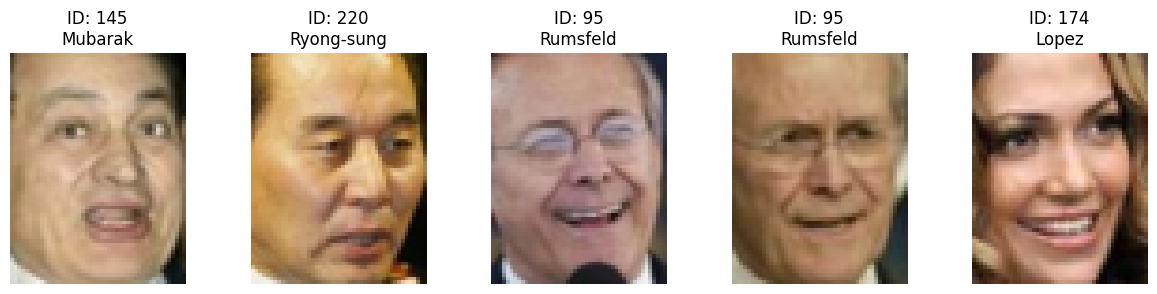

In [6]:
# @title Visualize Random Samples
def visualize_samples(X, y, names, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    np.random.seed(42)
    indices = np.random.choice(len(X), n, replace=False)
    for i, idx in enumerate(indices):
        # Permute back to (H, W, 3) for matplotlib
        img = X[idx].permute(1, 2, 0).numpy()
        label_id = y[idx].item()
        label_name = names[label_id].split()[-1] # Last name
        axes[i].imshow(img)
        axes[i].set_title(f"ID: {label_id}\n{label_name}")
        axes[i].axis('off')
    plt.show()

print("👁️ Visualizing Random Training Examples:")
visualize_samples(X_train, y_train, target_names)

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 1</b> Are you visualizing the same as in the reference notebook?
</div>

### 📏 Evaluation Metrics

To measure performance objectively, we will use two metrics on the **Unseen Test Set**:

1.  **Top-1 Accuracy:** For a query image, is the *closest* image in the database the correct person? (Simple check).
2.  **mAP (Mean Average Precision):** A stricter metric. It checks if *all* correct matches appear at the top of the retrieval list, not just the first one.

Review the `evaluate_metrics` function below. We will use this throughout the lab.

In [7]:
def evaluate_metrics(embeddings, labels):
    """
    Computes Top-1 Accuracy and Mean Average Precision (mAP) for retrieval.
    """
    # 1. Normalize Embeddings (Crucial for Cosine Similarity)
    embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
    
    # 2. Compute Cosine Similarity Matrix (N x N)
    sim_matrix = np.dot(embeddings, embeddings.T)
    
    # 3. Mask diagonal (ignore self-matching)
    np.fill_diagonal(sim_matrix, -1)
    
    # --- Metric 1: Top-1 Accuracy ---
    # Find the index of the most similar image
    nearest_indices = np.argmax(sim_matrix, axis=1)
    predicted_labels = labels[nearest_indices]
    acc = accuracy_score(labels, predicted_labels)
    
    # --- Metric 2: Mean Average Precision (mAP) ---
    aps = []
    for i in range(len(labels)):
        # Ground truth: 1 if same class, 0 if diff
        y_true = (labels == labels[i])
        y_true[i] = False # Exclude self
        
        # If this person has no other images in test set, skip
        if np.sum(y_true) == 0:
            continue
            
        y_scores = sim_matrix[i]
        aps.append(average_precision_score(y_true, y_scores))
        
    mAP = np.mean(aps) if aps else 0.0
    
    return acc, mAP

def get_embeddings(model, loader):
    """Helper to extract all embeddings from a model"""
    model.eval().to(device)
    embeddings = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x) # Forward pass
            embeddings.append(emb.cpu().numpy())
            labels.append(y.numpy())
    return np.vstack(embeddings), np.concatenate(labels)

<div class="alert alert-block alert-warning">
<b>📝 Reflection 1</b> 

<i>Describe in the following in your own words what the two evaluation measures are doing. Look up the documentation of the used function if needed.</i>

Your text

</div>

# Part 1: Training from Scratch

In this section, we assume we **do not** have a pretrained model. We must train a Convolutional Neural Network (CNN) from random initialization.

**The Challenge:**
Our dataset is "hard": many classes (400+), but very few examples per class (5-10).
A standard classifier (Softmax) will struggle to generalize here.

**Hypothesis:**
ArcFace (Metric Learning) should outperform Softmax because its **angular margin** forces the model to learn tight prototypes even with sparse data.

### 📉 Baseline 0: Raw Pixels
First, let's see how well we do with **Zero Learning**. We just flatten the images and compare pixel values.

In [8]:
# 1. Flatten Raw Pixels (N, 3*H*W)
X_test_flat = X_test.reshape(len(X_test), -1).numpy()

# 2. Evaluate
pixel_acc, pixel_map = evaluate_metrics(X_test_flat, y_test.numpy())

print(f"📊 Baseline (Raw Pixels) Results:")
print(f"   Top-1 Accuracy: {pixel_acc*100:.2f}%")
print(f"   mAP:            {pixel_map*100:.2f}%")
print("   (Note: This is your lower bound. Any model must beat this!)")

📊 Baseline (Raw Pixels) Results:
   Top-1 Accuracy: 27.07%
   mAP:            8.38%
   (Note: This is your lower bound. Any model must beat this!)


<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 2</b> Are performances the same as the ones in the reference notebook?
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection 2</b> 

<i>What are these results telling us? Are these good or bad results? Why are we using two different measures? What complementary information are they telling us? Why is this relevant to metric learning?</i>

Your text

</div>

### 🧠 Step 1.1: Define the Backbone

We need a simple CNN to map images to embeddings.

<div class="alert alert-block alert-info">
<b>☑️ TODO 1</b>

Complete the `FaceBackbone` class.
* Use 3 Convolutional Blocks.
* Use `nn.Conv2d`, `nn.BatchNorm2d`, `nn.ReLU`, and `nn.MaxPool2d`.
* End with an `AdaptiveAvgPool2d` and a `Linear` layer to project to `embedding_dim`.
</div>

In [ ]:
class FaceBackbone(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        
        # TODO: Define 3 Conv Blocks
        # Hint: Conv2d(in, out, 3, padding=1) -> BN -> ReLU -> MaxPool(2)
        # Block 1: 3 -> 32 channels
        # Block 2: 32 -> 64 channels
        # Block 3: 64 -> 128 channels
        
        self.features = nn.Sequential(
            # <YOUR CODE HERE>
            
            # </YOUR CODE HERE>
        )
        
        # Global Average Pooling to handle any image size -> (B, 128, 1, 1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Final Projection
        self.fc = nn.Linear(128, embedding_dim)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.flatten(1) # (B, 128)
        x = self.fc(x)
        return x
    
# Sanity Check
dummy_net = FaceBackbone()
dummy_out = dummy_net(torch.randn(2, 3, 62, 47))
print(f"✅ Backbone Output Shape: {dummy_out.shape} (Should be [2, 128])")

✅ Backbone Output Shape: torch.Size([2, 128]) (Should be [2, 128])


<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 3</b> Is your output shape correct?
</div>

### 📐 Step 1.2: The Metric Head (ArcFace)

This is the core of the lab. You will implement the **ArcFace Head**.

**The Math:**
Recall the the ArcFace loss is written as follows:

$$
L(x_i,y_i) = − \log \frac{e^{s \cdot \cos(\theta_{y_i} + m)}}{e^{s \cdot \cos(\theta_{y_i} + m)} + \sum_{j \neq {y_i}} e^{s \cdot \cos(\theta_j)}}
$$

While for a standard cross-entropy, we would have:

$$
L(x_i,y_i) = − \log \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$$

We can hence reason in terms of logits. For a standard cross-entropy, we will compute the logit with a linear layer.

For ArcFace, we have to do something different. Specifically, we need to compute the angle:

$$\theta_y = arccos(W_y^T x_i)$$

for all classes $y$.

Then compute logits making sure that we add the margin only to the positive class:

$$
\text{logit}_j = 
\begin{cases} 
s \cdot \cos(\theta_{y_i} + m) & \text{if } j = y_i \text{ (Target Class)} \\
s \cdot \cos(\theta_j) & \text{if } j \neq y_i \text{ (Other Classes)}
\end{cases}
$$

<div class="alert alert-block alert-info">
<b>☑️ TODO 2</b>

Implement the `MetricLinear` class.
1.  **Normalize** weights ($W$) and inputs ($x$) to unit length.
2.  Compute **Cosine Similarity**: $\cos \theta = x \cdot W$.
3.  **Add Margin:** For the ground-truth class $y$, calculate $\cos(\theta + m)$.
    * *Hint:* Use `torch.acos()` to get $\theta$, add $m$, then `torch.cos()`.
    * *Hint:* `torch.clamp` cosine to `[-0.99, 0.99]` to avoid NaNs in `acos`.
4.  **Scale:** Multiply by $s$.
</div>

In [ ]:
class MetricLinear(nn.Module):
    """This class computes the logits to be passed to the softmax / cross-entropy loss.
    It can operate in two modes:
    1. Standard Linear Layer (Softmax)
    2. ArcFace Layer (with margin)"""
    def __init__(self, in_features, out_features, use_arcface=False, s=20.0, m=0.10):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_arcface = use_arcface # If False, behaves like standard Linear layer
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, labels=None):
        # 1. Softmax Mode (Linear)
        if not self.use_arcface:
            # TODO: Standard Linear Layer Wx (no bias)
            # <YOUR CODE HERE>

            # </YOUR CODE HERE>

        # 2. ArcFace Mode
        # TODO: Normalize Weights and Input
        # <YOUR CODE HERE>

        # </YOUR CODE HERE>
        
        # TODO: Calculate Cosine Similarity
        # <YOUR CODE HERE>

        # </YOUR CODE HERE>
        
        # Inference Mode (No labels provided) -> Return scaled cosine
        if labels is None:
            return cosine * self.s

        # TODO: Add Margin (m) to target classes
        # Hint: Use one_hot encoding for labels
        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>
        
        return output * self.s

### ⚡ Step 1.3: The Lightning Module

We combine the backbone and head into a training system.
Notice how we log `train_loss` and `train_acc`.

In [11]:
class FaceSystem(pl.LightningModule):
    def __init__(self, backbone, use_arcface=False):
        super().__init__()
        self.backbone = backbone
        # We ONLY train on the TRAIN classes (Closed set training)
        self.head = MetricLinear(EMBEDDING_DIM, NUM_TRAIN_CLASSES, use_arcface=use_arcface)
        self.criterion = nn.CrossEntropyLoss()
        
        # Storage for plotting curves later
        self.train_loss_history = []
        self.train_acc_history = []

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        emb = self.backbone(x)
        logits = self.head(emb, y)
        loss = self.criterion(logits, y)
        
        # Calculate Accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()
        
        # Log to WandB
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        
        # Store locally
        self.train_loss_history.append(loss.item())
        self.train_acc_history.append(acc.item())
        
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)

# Helper function to plot curves immediately
def plot_training_curves(model, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    # Loss
    ax[0].plot(model.train_loss_history, alpha=0.5)
    ax[0].set_title(f"{title} - Loss")
    ax[0].set_xlabel("Steps")
    # Acc
    ax[1].plot(model.train_acc_history, color='orange', alpha=0.5)
    ax[1].set_title(f"{title} - Accuracy")
    ax[1].set_xlabel("Steps")
    plt.show()

<div class="alert alert-block alert-warning">
<b>📝 Reflection 3</b> 

<i>Describe in the following in your own words what the Lightning boilerplate module will do during training.</i>

Your text

</div>

### 🏃‍♂️ Experiment 1: CNN + Softmax vs. CNN + ArcFace

Now we train two models from scratch.
* **Model A:** Standard Softmax.
* **Model B:** ArcFace.

**What to expect:**
Since we are training from scratch on a hard dataset (few-shot), Softmax should struggle. ArcFace should perform significantly better.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🔵 Training CNN + Softmax (Baseline)...


wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone  │ FaceBackbone     │  110 K │ train │     0 │
│ 1 │ head      │ MetricLinear     │ 40.6 K │ train │     0 │
│ 2 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 150 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 150 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 18                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


wandb: WARNING Unable to render Widget, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


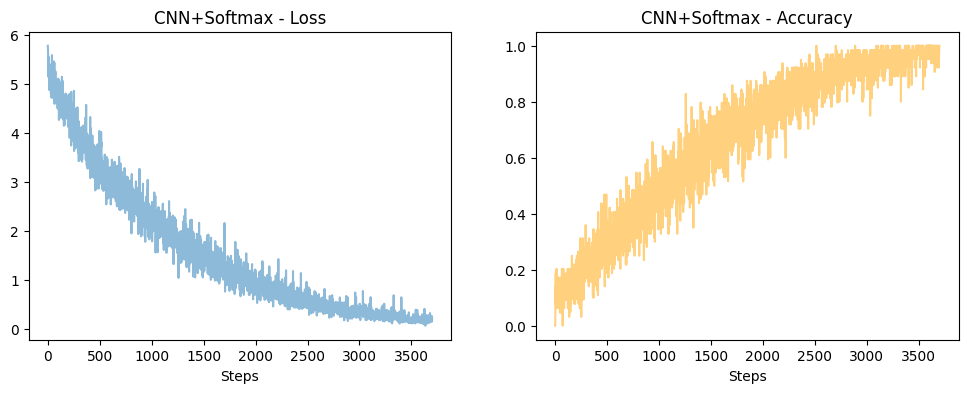

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



🟠 Training CNN + ArcFace...


wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone  │ FaceBackbone     │  110 K │ train │     0 │
│ 1 │ head      │ MetricLinear     │ 40.6 K │ train │     0 │
│ 2 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 150 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 150 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 18                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=50` reached.


wandb: WARNING Unable to render Widget, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core
wandb: WARNING Unable to render HTML, can't import display from ipython.core


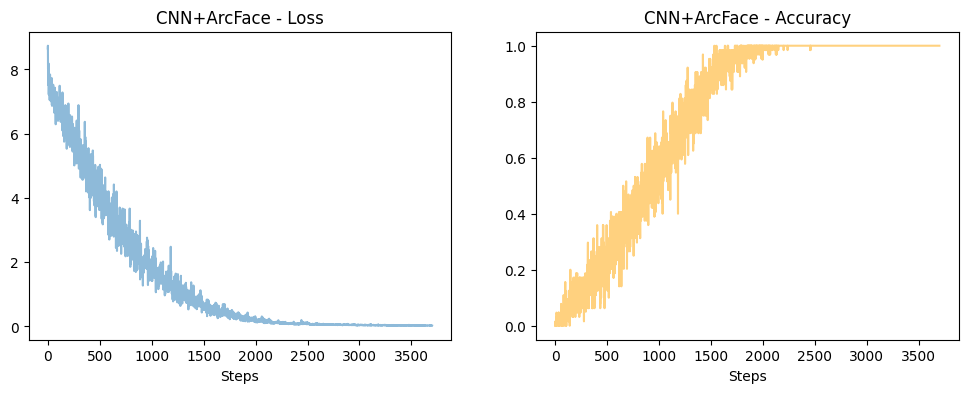

In [12]:
# 1. Train Softmax Baseline
print("\n🔵 Training CNN + Softmax (Baseline)...")
cnn_soft = FaceBackbone(EMBEDDING_DIM)
model_cnn_soft = FaceSystem(cnn_soft, use_arcface=False)

logger_soft = WandbLogger(project=WANDB_PROJECT, name="CNN_Softmax")
trainer_soft = pl.Trainer(
    max_epochs=MAX_EPOCHS_PART1, # 50 Epochs
    accelerator="auto", 
    devices=1,
    logger=logger_soft,
    enable_checkpointing=False,
    log_every_n_steps=10
)
trainer_soft.fit(model_cnn_soft, train_loader)
wandb.finish()
plot_training_curves(model_cnn_soft, "CNN+Softmax")

# 2. Train ArcFace
print("\n🟠 Training CNN + ArcFace...")
cnn_arc = FaceBackbone(EMBEDDING_DIM)
model_cnn_arc = FaceSystem(cnn_arc, use_arcface=True)

logger_arc = WandbLogger(project=WANDB_PROJECT, name="CNN_ArcFace")
trainer_arc = pl.Trainer(
    max_epochs=MAX_EPOCHS_PART1, # 50 Epochs
    accelerator="auto", 
    devices=1,
    logger=logger_arc,
    enable_checkpointing=False,
    log_every_n_steps=10
)
trainer_arc.fit(model_cnn_arc, train_loader)
wandb.finish()
plot_training_curves(model_cnn_arc, "CNN+ArcFace")

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 4</b>

Monitor training curves through wandb and compare them to the ones shown in the reference notebook. Are they showing a similar picture? Double check your code to make sure you obtain similar results.
</div>

Let's now obtain quantitative evaluations for the two models and compare them to pixel-based retrieval:

In [13]:
print("\n📊 Evaluating Part 1 Models (Weak Backbone)...")

# Get Embeddings
e_cnn_d, l_cnn_d = get_embeddings(dummy_net, test_loader)
acc_dummy, map_dummy = evaluate_metrics(e_cnn_d, l_cnn_d)

e_cnn_s, l_cnn_s = get_embeddings(model_cnn_soft, test_loader)
acc_soft, map_soft = evaluate_metrics(e_cnn_s, l_cnn_s)

e_cnn_a, l_cnn_a = get_embeddings(model_cnn_arc, test_loader)
acc_arc, map_arc = evaluate_metrics(e_cnn_a, l_cnn_a)

# Print Table
print(f"{'Method':<20} | {'Acc':<10} | {'mAP':<10}")
print("-" * 45)
print(f"{'Pixels':<20} | {pixel_acc*100:.2f}%     | {pixel_map*100:.2f}%")
print(f"{'Untrained CNN':<20} | {acc_dummy*100:.2f}%     | {map_dummy*100:.2f}%")
print(f"{'CNN+Softmax':<20} | {acc_soft*100:.2f}%     | {map_soft*100:.2f}%")
print(f"{'CNN+ArcFace':<20} | {acc_arc*100:.2f}%     | {map_arc*100:.2f}%")


📊 Evaluating Part 1 Models (Weak Backbone)...
Method               | Acc        | mAP       
---------------------------------------------
Pixels               | 27.07%     | 8.38%
Untrained CNN        | 9.82%     | 5.25%
CNN+Softmax          | 45.09%     | 25.20%
CNN+ArcFace          | 55.53%     | 29.26%


<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 5</b>

Do you obtain similar quantitative results?
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection 4</b> 

<i>Comment on the results above considering both Acc and mAP. What is happening? Is this expected?</i>

Your text

</div>

### 🔎 Visualizing Retrieval

Numbers are good, but seeing is believing.
The code below picks random query images from the Test Set and shows the **Top-1 Match** found by each model.

Look for cases where Softmax fails (retrieves wrong person) but ArcFace succeeds.


🔎 Visualizing Top-1 Retrieval Comparison...


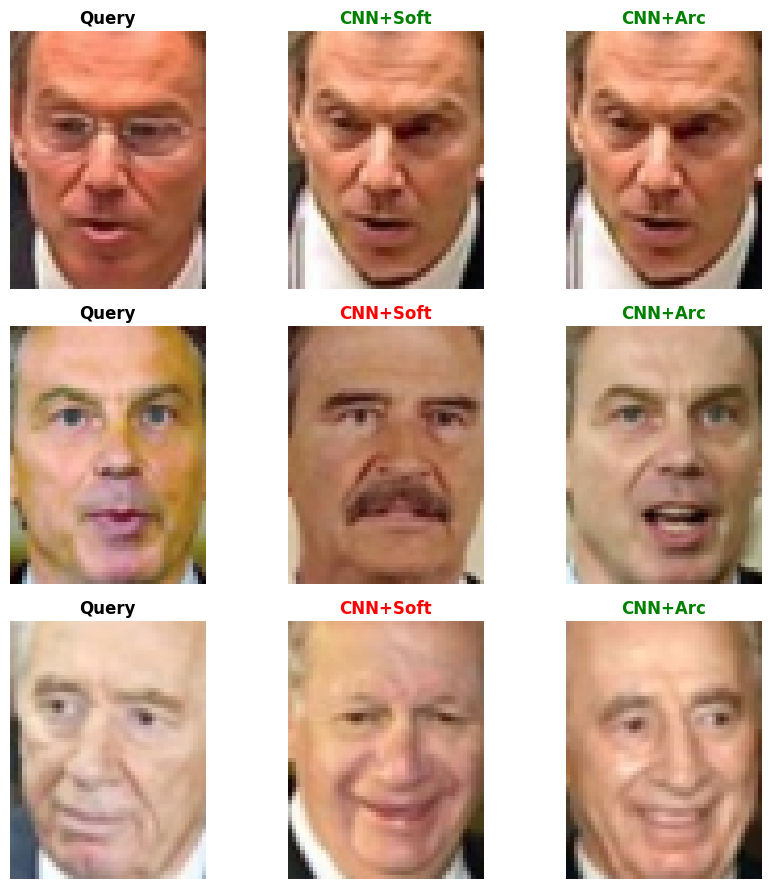

In [14]:
def visualize_retrieval(models_dict, X_test, y_test, target_names, n=3):
    print(f"\n🔎 Visualizing Top-1 Retrieval Comparison...")
    
    # Pre-compute sims for efficiency
    model_data = {}
    for name, model in models_dict.items():
        model.eval().to(device)
        with torch.no_grad():
            emb = model(X_test.to(device)).cpu().numpy()
        emb = emb / (np.linalg.norm(emb, axis=1, keepdims=True) + 1e-8)
        sims = np.dot(emb, emb.T)
        np.fill_diagonal(sims, -1)
        model_data[name] = sims

    # Plot
    np.random.seed(42)
    indices = np.random.choice(len(X_test), n, replace=False)
    cols = 1 + len(models_dict) 
    fig, axes = plt.subplots(n, cols, figsize=(3 * cols, 3 * n), squeeze=False)
    
    for i, query_idx in enumerate(indices):
        query_img = X_test[query_idx].permute(1, 2, 0).numpy()
        query_lbl = y_test[query_idx].item()
        
        axes[i, 0].imshow(query_img)
        axes[i, 0].set_title("Query", fontweight='bold')
        axes[i, 0].axis('off')
        
        for m_idx, (name, sims) in enumerate(model_data.items()):
            retrieved_idx = np.argmax(sims[query_idx])
            result_img = X_test[retrieved_idx].permute(1, 2, 0).numpy()
            result_lbl = y_test[retrieved_idx].item()
            
            color = 'green' if query_lbl == result_lbl else 'red'
            ax = axes[i, m_idx + 1]
            ax.imshow(result_img)
            ax.set_title(f"{name}", color=color, fontweight='bold')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_retrieval({"CNN+Soft": model_cnn_soft, "CNN+Arc": model_cnn_arc}, X_test, y_test, target_names)

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 6</b>

Do you obtain similar qualitative results?
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection 5</b> 

<i>Briefly comment on the qualitative results above.</i>

Your text

</div>

Finally, we use t-SNE to see how the different approach organize the embedding space. t-SNE is a technique which performs a non-linear mapping of high-dimensional embeddings to lower dimensions aiming to respect local similarities for visualization.


🗺️ Generating t-SNE for Raw Pixels...


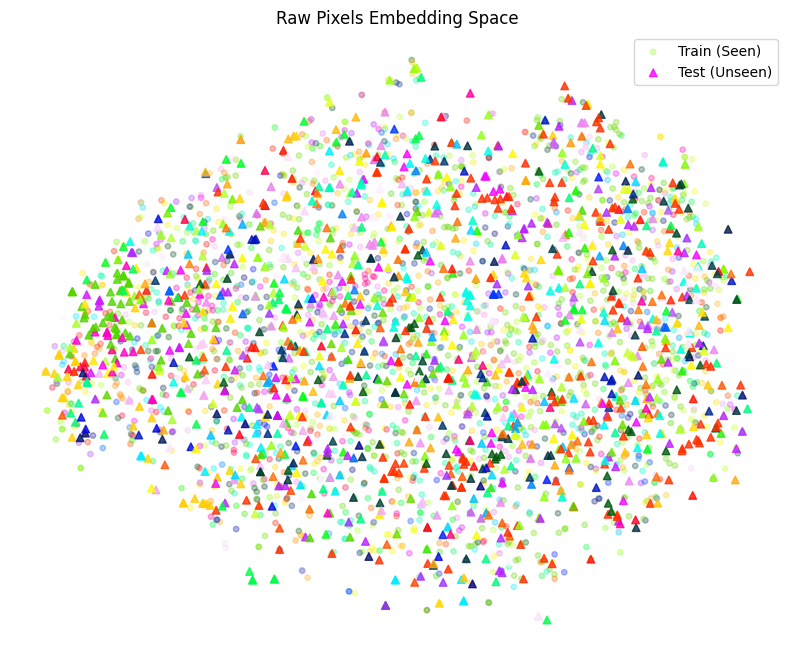


🗺️ Generating t-SNE for Untrained CNN...


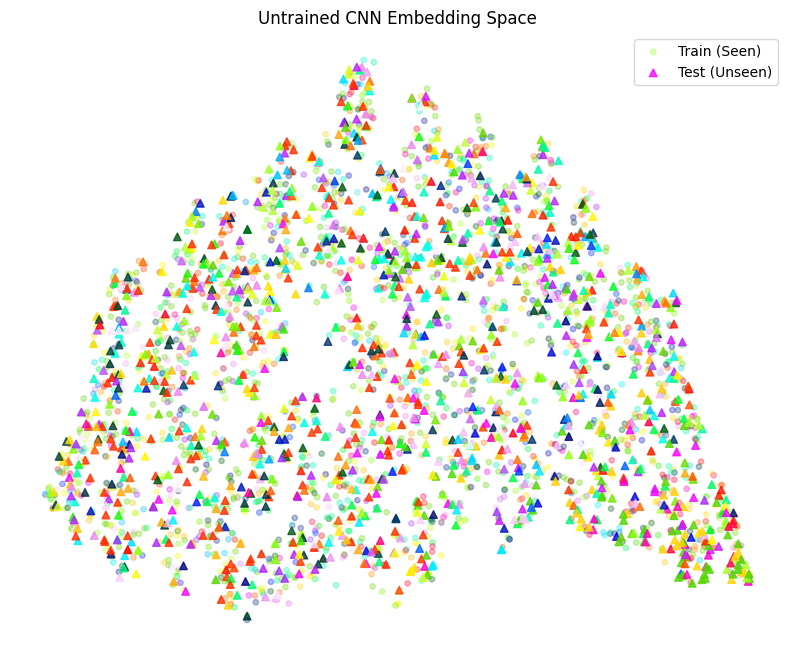


🗺️ Generating t-SNE for CNN+Softmax...


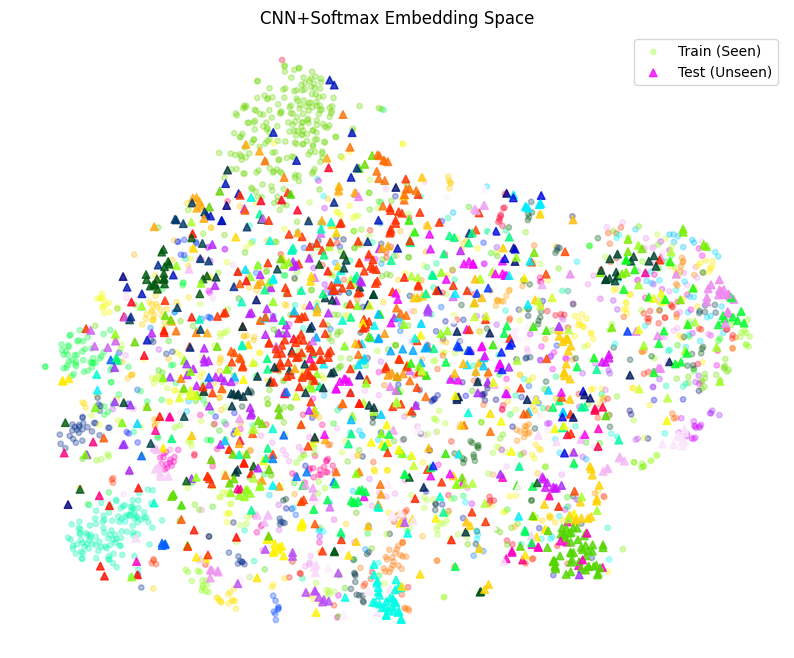


🗺️ Generating t-SNE for CNN+ArcFace...


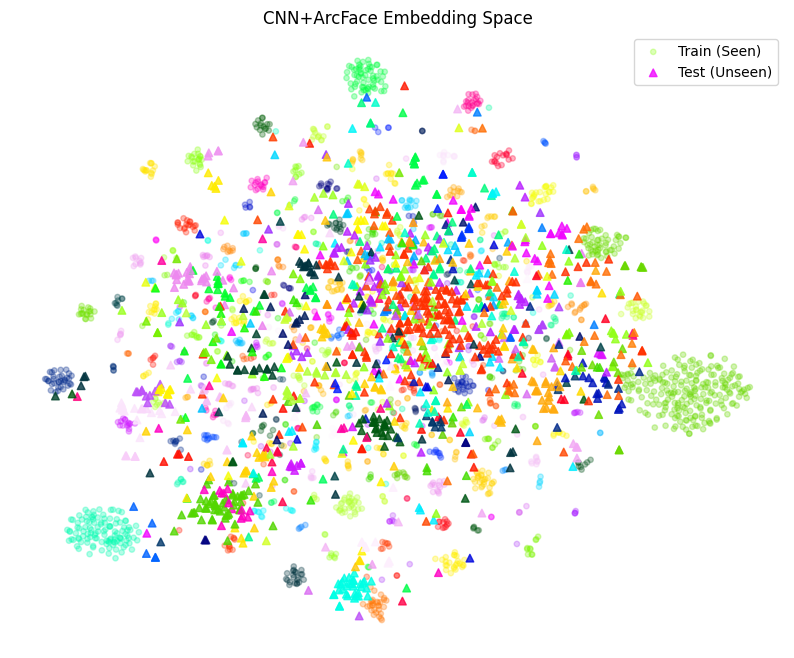

In [15]:
# @title 🗺️ Visualizing Embedding Spaces (Part 1 - Standalone Plots)

def visualize_tsne_standalone(model, name, X_train, y_train, X_test, y_test, is_pixels=False):
    print(f"\n🗺️ Generating t-SNE for {name}...")
    
    # 1. Get Representations
    if is_pixels:
        # For pixels, just flatten
        emb_train = X_train.reshape(len(X_train), -1).numpy()
        emb_test = X_test.reshape(len(X_test), -1).numpy()
    else:
        # For models, extract features
        model.eval().to(device)
        with torch.no_grad():
            emb_train = model(X_train.to(device)).cpu().numpy()
            emb_test = model(X_test.to(device)).cpu().numpy()
            
    # 2. Combine for joint t-SNE
    combined_data = np.vstack([emb_train, emb_test])
    n_train = len(emb_train)
    
    # 3. Fit t-SNE
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
    proj_combined = tsne.fit_transform(combined_data)
    
    proj_tr = proj_combined[:n_train]
    proj_te = proj_combined[n_train:]
    
    # 4. Plot Standalone
    plt.figure(figsize=(10, 8))
    cmap_name = 'gist_ncar'
    
    # Plot Train (Circles)
    plt.scatter(proj_tr[:, 0], proj_tr[:, 1], c=y_train, cmap=cmap_name, 
                marker='o', s=15, alpha=0.3, label='Train (Seen)')
    
    # Plot Test (Triangles)
    plt.scatter(proj_te[:, 0], proj_te[:, 1], c=y_test, cmap=cmap_name, 
                marker='^', s=30, alpha=0.8, label='Test (Unseen)')
    
    plt.title(f"{name} Embedding Space")
    plt.legend()
    plt.axis('off')
    plt.show()

# --- Run Visualizations ---

# 1. Raw Pixels
# Sub-sample for speed if needed, but plotting all is fine for ~3000 pts
indices = np.random.choice(len(X_train), min(2000, len(X_train)), replace=False)
X_tr_viz, y_tr_viz = X_train[indices], y_train[indices]

visualize_tsne_standalone(None, "Raw Pixels", X_tr_viz, y_tr_viz, X_test, y_test, is_pixels=True)

# 2. Untrained CNN (Random Init)
# Need dummy_net from earlier
dummy_net = FaceBackbone().to(device) 
visualize_tsne_standalone(dummy_net, "Untrained CNN", X_tr_viz, y_tr_viz, X_test, y_test)

# 3. CNN + Softmax
visualize_tsne_standalone(model_cnn_soft, "CNN+Softmax", X_tr_viz, y_tr_viz, X_test, y_test)

# 4. CNN + ArcFace
visualize_tsne_standalone(model_cnn_arc, "CNN+ArcFace", X_tr_viz, y_tr_viz, X_test, y_test)

<div class="alert alert-block alert-warning">
<b>📝 Reflection 6</b> 

<i>While the code is computing ... inspect it and explain in your words what it does.</i>

Your text

</div>

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 7</b>

Do you obtain similar visualizations? Note that t-SNE is stochastic so absolute arrangements may change, but you should see similar grouping behaviors.
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection 7</b> 

<i>Briefly comment on the visualizations above.</i>

Your text

</div>

<div class="alert alert-block alert-success">
<b>🏁 Milestone 1</b> You completed part 1!
</div>

# Part 2: Foundation Models

Training from scratch is hard. In modern industry, we start with **Foundation Models**.

We will use **DinoV2** (by Meta), a Vision Transformer trained on 142 million images using self-supervised learning.

**The Experiments:**
1.  **Dino (Raw):** Extract features and use them directly.
2.  **Dino + Softmax:** Train a small MLP on top.
3.  **Dino + ArcFace:** Train a small MLP with ArcFace.

**The Question:**
Does ArcFace still provide a massive boost when the backbone is already superhuman? Or does a simple Softmax catch up?

Let's start by extracting features:

In [16]:
# 1. Load DinoV2
print("🦖 Loading DinoV2 (Small)...")
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2.to(device)
dinov2.eval()

# 2. Extraction Helper
def extract_dino_features(loader):
    features = []
    labels = []
    print("   Extracting features...")
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            # Resize to 224x224 for ViT
            x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            feats = dinov2(x_resized) # [B, 384]
            features.append(feats.cpu())
            labels.append(y)
    return torch.cat(features), torch.cat(labels)

print("➡️ Extracting Train Features...")
X_train_dino, y_train_dino = extract_dino_features(train_loader)
print("➡️ Extracting Test Features...")
X_test_dino, y_test_dino = extract_dino_features(test_loader)

# 3. Create Feature Loaders (Much faster to train!)
train_loader_dino = DataLoader(TensorDataset(X_train_dino, y_train_dino), batch_size=BATCH_SIZE, shuffle=True)
test_loader_dino = DataLoader(TensorDataset(X_test_dino, y_test_dino), batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Features Ready. Shape: {X_train_dino.shape}")

🦖 Loading DinoV2 (Small)...


Using cache found in /home/furnari/.cache/torch/hub/facebookresearch_dinov2_main
/home/furnari/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/furnari/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/furnari/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


➡️ Extracting Train Features...
   Extracting features...
➡️ Extracting Test Features...
   Extracting features...
✅ Features Ready. Shape: torch.Size([4692, 384])


Let's now define an MLP backbone which will replace our previous embedding network. The input will be $384$, while the output will be $128$. We set the hidden size to $512$.

<b>☑️ TODO 3</b>

Complete the `MLPBackbone` class.
* Use 1 Hidden Layer
* Add in sequence a linear layer, a batch normalization, a rely and another linear layer.
</div>

In [ ]:
# Define MLP Backbone (Input 384 -> Embed 128)
class MLPBackbone(nn.Module):
    def __init__(self, input_dim, embedding_dim=128, hidden_dim=512):
        super().__init__()
        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>
    def forward(self, x):
        return self.net(x)

dummy_net = MLPBackbone(input_dim=384)
dummy_out = dummy_net(torch.randn(2, 384))
print(f"✅ MLP Backbone Output Shape: {dummy_out.shape} (Should be [2, 128])")

✅ MLP Backbone Output Shape: torch.Size([2, 128]) (Should be [2, 128])


<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 8</b>

Is the output shape correct?
</div>

Now to the training:

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.



🔵 Training Dino+MLP + Softmax...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone  │ MLPBackbone      │  263 K │ train │     0 │
│ 1 │ head      │ MetricLinear     │ 40.6 K │ train │     0 │
│ 2 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 304 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 304 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/home/furnari/miniconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


`Trainer.fit` stopped: `max_epochs=10` reached.


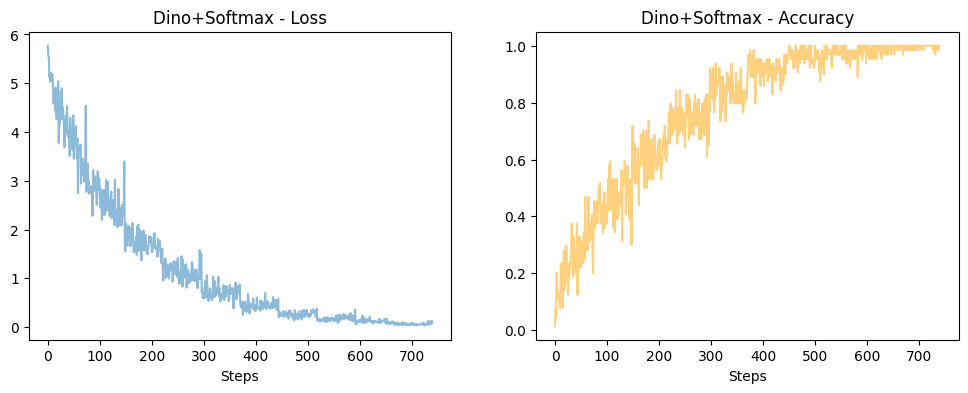

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



🟠 Training Dino+MLP + ArcFace...


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone  │ MLPBackbone      │  263 K │ train │     0 │
│ 1 │ head      │ MetricLinear     │ 40.6 K │ train │     0 │
│ 2 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 304 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 304 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 8                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


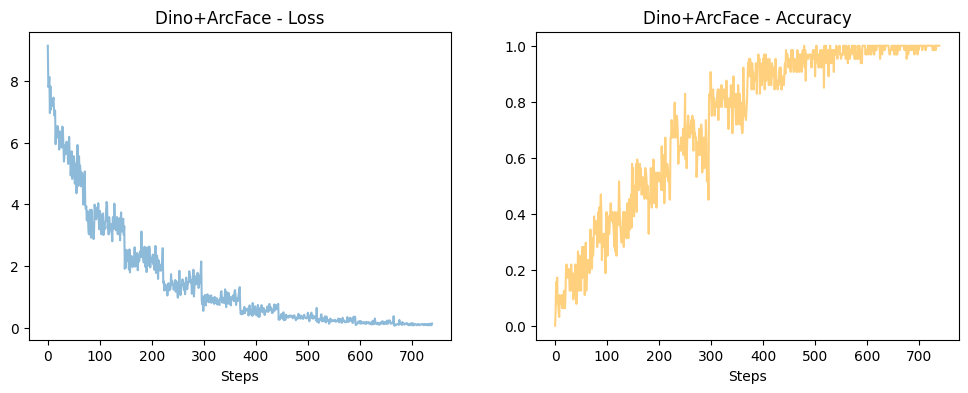

In [18]:
# 1. Train Dino+Softmax
print("\n🔵 Training Dino+MLP + Softmax...")
mlp_soft = MLPBackbone(input_dim=384, embedding_dim=EMBEDDING_DIM)
model_dino_soft = FaceSystem(mlp_soft, use_arcface=False)

trainer = pl.Trainer(max_epochs=MAX_EPOCHS_PART2, accelerator="auto", enable_checkpointing=False, logger=False)
trainer.fit(model_dino_soft, train_loader_dino)
plot_training_curves(model_dino_soft, "Dino+Softmax")

# 2. Train Dino+ArcFace
print("\n🟠 Training Dino+MLP + ArcFace...")
mlp_arc = MLPBackbone(input_dim=384, embedding_dim=EMBEDDING_DIM)
model_dino_arc = FaceSystem(mlp_arc, use_arcface=True)

trainer = pl.Trainer(max_epochs=MAX_EPOCHS_PART2, accelerator="auto", enable_checkpointing=False, logger=False)
trainer.fit(model_dino_arc, train_loader_dino)
plot_training_curves(model_dino_arc, "Dino+ArcFace")

<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 9</b>

Are training curves similar to the reference notebook?
</div>

Let's now compute quantitative results:

In [19]:
print("\n📊 Final Evaluation: All Models")

# 1. Raw Dino (Zero-Shot)
acc_raw, map_raw = evaluate_metrics(X_test_dino.numpy(), y_test_dino.numpy())

# 2. Trained MLPs
e_dino_s, l_dino_s = get_embeddings(model_dino_soft, test_loader_dino)
acc_ds, map_ds = evaluate_metrics(e_dino_s, l_dino_s)

e_dino_a, l_dino_a = get_embeddings(model_dino_arc, test_loader_dino)
acc_da, map_da = evaluate_metrics(e_dino_a, l_dino_a)

print(f"{'Method':<20} | {'Acc':<10} | {'mAP':<10}")
print("-" * 45)
print(f"{'Dino (Raw)':<20} | {acc_raw*100:.2f}%     | {map_raw*100:.2f}%")
print(f"{'Dino+Softmax':<20} | {acc_ds*100:.2f}%     | {map_ds*100:.2f}%")
print(f"{'Dino+ArcFace':<20} | {acc_da*100:.2f}%     | {map_da*100:.2f}%")


📊 Final Evaluation: All Models
Method               | Acc        | mAP       
---------------------------------------------
Dino (Raw)           | 42.38%     | 18.40%
Dino+Softmax         | 61.56%     | 36.30%
Dino+ArcFace         | 61.56%     | 33.33%


<div class="alert alert-block alert-danger">
<b>🛑 Checkpoint 10</b>

Do you obtain similar quantitative results compared to the reference notebook?
</div>

<div class="alert alert-block alert-warning">
<b>📝 Reflection 8</b> 

<i>Comment on the results, comparing them to the previous iteration. What is happening? What has changed? Is ArcFace still competitive? Why?</i>

Your text

</div>

Finally, let's plot the t-SNE visualizations also in this case:


🗺️ Generating t-SNE for DinoV2 (Raw Features)...


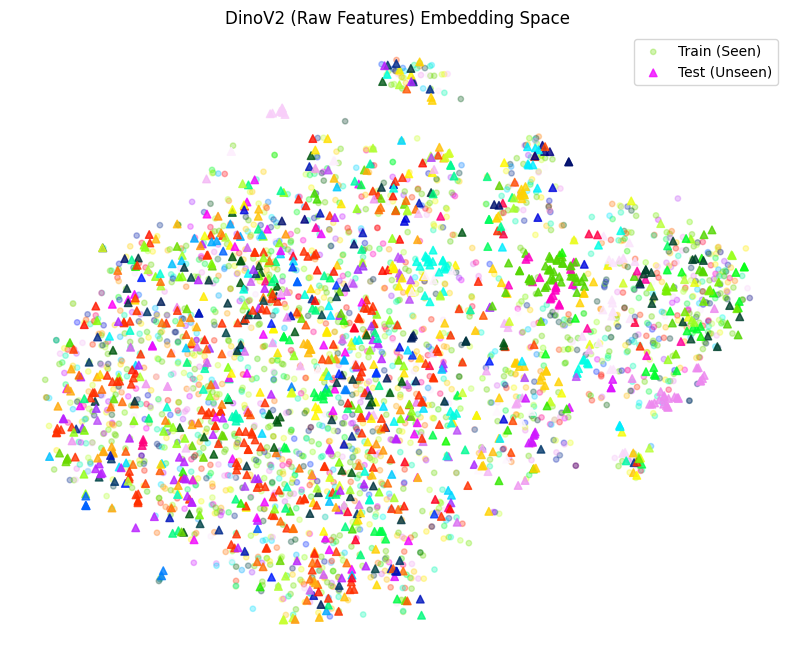


🗺️ Generating t-SNE for Dino + Softmax...


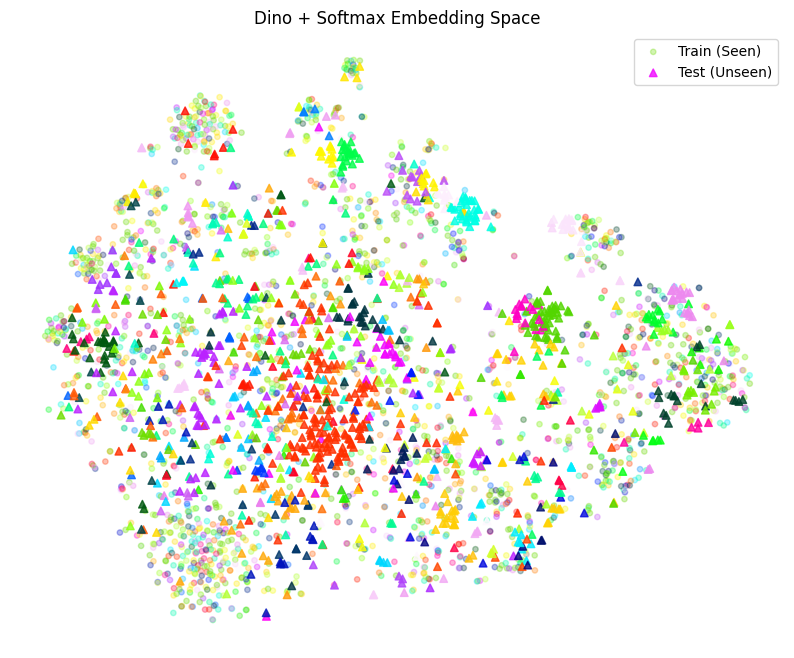


🗺️ Generating t-SNE for Dino + ArcFace...


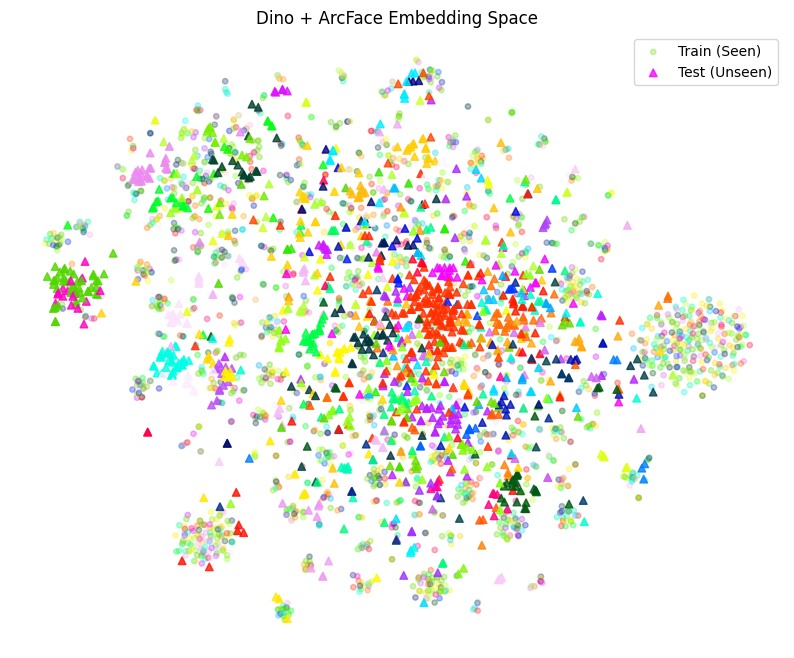

In [20]:
# @title 🗺️ Visualizing Embedding Spaces (Part 2 - Foundation Models)

def visualize_tsne_part2(model, name, X_train_feats, y_train, X_test_feats, y_test):
    print(f"\n🗺️ Generating t-SNE for {name}...")
    
    # 1. Get Representations
    # If model is None, we just use the raw features (Dino Raw)
    if model is None:
        emb_train = X_train_feats.numpy()
        emb_test = X_test_feats.numpy()
    else:
        model.eval().to(device)
        with torch.no_grad():
            emb_train = model(X_train_feats.to(device)).cpu().numpy()
            emb_test = model(X_test_feats.to(device)).cpu().numpy()
            
    # 2. Combine for joint t-SNE
    combined_data = np.vstack([emb_train, emb_test])
    n_train = len(emb_train)
    
    # 3. Fit t-SNE
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
    proj_combined = tsne.fit_transform(combined_data)
    
    proj_tr = proj_combined[:n_train]
    proj_te = proj_combined[n_train:]
    
    # 4. Plot Standalone
    plt.figure(figsize=(10, 8))
    cmap_name = 'gist_ncar'
    
    # Plot Train (Circles)
    # Using a subset of training points for clarity if needed, but plotting all is fine here
    plt.scatter(proj_tr[:, 0], proj_tr[:, 1], c=y_train, cmap=cmap_name, 
                marker='o', s=15, alpha=0.3, label='Train (Seen)')
    
    # Plot Test (Triangles)
    plt.scatter(proj_te[:, 0], proj_te[:, 1], c=y_test, cmap=cmap_name, 
                marker='^', s=30, alpha=0.8, label='Test (Unseen)')
    
    plt.title(f"{name} Embedding Space")
    plt.legend()
    plt.axis('off')
    plt.show()

# --- Run Visualizations ---

# Sub-sample indices for training data (to match Part 1 viz density)
indices = np.random.choice(len(X_train_dino), min(2000, len(X_train_dino)), replace=False)
X_tr_dino_viz, y_tr_viz = X_train_dino[indices], y_train[indices]

# 1. Dino Raw (Zero-Shot)
visualize_tsne_part2(None, "DinoV2 (Raw Features)", X_tr_dino_viz, y_tr_viz, X_test_dino, y_test)

# 2. Dino + Softmax
visualize_tsne_part2(model_dino_soft, "Dino + Softmax", X_tr_dino_viz, y_tr_viz, X_test_dino, y_test)

# 3. Dino + ArcFace
visualize_tsne_part2(model_dino_arc, "Dino + ArcFace", X_tr_dino_viz, y_tr_viz, X_test_dino, y_test)

<div class="alert alert-block alert-warning">
<b>📝 Reflection 9</b> 

<i>Comment on the visualizations above.</i>

Your text

</div>

<div class="alert alert-block alert-success">
<b>🏁 Milestone 2</b> You completed part 2!
</div>

## 🚀 Part 3: Extensions & Homework

Now that you have implemented ArcFace and compared it with standard baselines, here are some challenging extensions to deepen your understanding.

### 📝 1. Implement Triplet Loss (Hard Mining)
ArcFace is a "Proxy-based" method (comparing data to class centers). A classic alternative is **Pair-based** metric learning.
* **Task:** Implement `TripletLoss` with **Online Semi-Hard Mining**.
* **The Challenge:** You cannot just sample random triplets (they are too easy!). You must write a custom sampler or miner that finds triplets within a batch where `d(A, P) < d(A, N) < d(A, P) + margin`.
* **Comparison:** Does Triplet Loss converge faster or slower than ArcFace on the weak CNN backbone?

### 🧪 2. The "Metric Learning Reality Check" on Large Data
We observed that on a small subset of LFW, Dino+Softmax performed extremely well.
* **Task:** Re-run this entire pipeline on a larger, harder dataset like **CASIA-WebFace** or **MS1M** (or a larger subset of LFW if computation allows).
* **Hypothesis:** As the number of classes increases (e.g., >10,000) and the number of samples per class decreases, the "Softmax" baseline should start to degrade significantly compared to ArcFace. Verify this.

### 🔍 3. Visualize the "Norm" (Magnitude)
We hypothesized that ArcFace hurts DinoV2 performance because it normalizes features, discarding magnitude information.
* **Task:** Plot a histogram of the feature norms ($||f(x)||_2$) for the **Raw Dino** features.
* **Question:** Do "easy" images have higher norms than "hard/blurry" images? If so, ArcFace is throwing away this confidence signal.

### 🛠️ 4. Hyperparameter Ablation
* **Margin ($m$):** We used $m=0.1$. Try increasing it to $0.5$ (standard for large datasets). Does training collapse on this small dataset?
* **Scale ($s$):** We used $s=20$. What happens if you lower it to $s=1$? (Hint: The gradients might vanish).

---
**Submission:**
Please wrap up your code, ensure your WandB logs are synced and you link is in the notebook, and submit your notebook via email.